In [15]:
# Visualize the provided 3D trajectory and speed (static 3D plot + speed-over-time + optional GIF animation)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.animation import FuncAnimation, PillowWriter

# ----- User-supplied parameters/code -----
MAX_SPEED     = 12.0   # m/s (hard cap)
MAX_ACCEL     = 3.0    # m/s^2 (hard cap)
MARGIN        = 0.995  # safety factor vs theory bounds
T             = 130.0  # duration (s)
DT            = 0.02   # timestep (s)
Z0            = 10.0   # altitude offset (m)
SEED          = 183    # RNG seed (change for a different “random” path)

# Component counts per axis (more = richer motion)
NX, NY, NZ = 8, 8, 4

# Random ranges (feel free to tweak)
# Frequencies in Hz (periods ~50–1000 s); vertical a tad slower
FX_RANGE = (0.0002, 0.003)
FY_RANGE = (0.0001, 0.0017)
FZ_RANGE = (0.0015, 0.010)

# Amplitude ranges in meters (horizontal > vertical)
AX_RANGE = (15.0, 60.0)
AY_RANGE = (12.0, 50.0)
AZ_RANGE = (4.0,  18.0)

def rand_components(n, frange, arange, rng):
    f  = rng.uniform(*frange, size=n)     # Hz
    A  = rng.uniform(*arange, size=n)     # m
    ph = rng.uniform(0, 2*np.pi, size=n)  # rad
    return A, f, ph

def build_soft_trajectory(t):
    rng = np.random.default_rng(SEED)

    Ax, fx, phx = rand_components(NX, FX_RANGE, AX_RANGE, rng)
    Ay, fy, phy = rand_components(NY, FY_RANGE, AY_RANGE, rng)
    Az, fz, phz = rand_components(NZ, FZ_RANGE, AZ_RANGE, rng)

    wx, wy, wz = 2*np.pi*fx, 2*np.pi*fy, 2*np.pi*fz

    # Worst-case bounds (independent of phases)
    Dx  = np.sum(Ax*wx);   Dy  = np.sum(Ay*wy);   Dz  = np.sum(Az*wz)
    Bv  = np.sqrt(Dx**2 + Dy**2 + Dz**2)

    D2x = np.sum(Ax*wx**2); D2y = np.sum(Ay*wy**2); D2z = np.sum(Az*wz**2)
    Ba  = np.sqrt(D2x**2 + D2y**2 + D2z**2)

    S_speed = (MARGIN*MAX_SPEED) / max(Bv, 1e-12)
    S_accel = (MARGIN*MAX_ACCEL) / max(Ba, 1e-12)
    S0 = min(S_speed, S_accel)

    def mix_sin(a, w, ph):    return (a[None,:]*np.sin(w[None,:]*t[:,None] + ph[None,:])).sum(axis=1)
    def mix_cos_w(a, w, ph):  return (a[None,:]*w[None,:]*np.cos(w[None,:]*t[:,None] + ph[None,:])).sum(axis=1)
    def mix_sin_w2(a, w, ph): return (a[None,:]*w[None,:]**2*np.sin(w[None,:]*t[:,None] + ph[None,:])).sum(axis=1)

    # Position / velocity / acceleration (analytic)
    x  = S0*mix_sin(Ax, wx, phx);   y  = S0*mix_sin(Ay, wy, phy);   z  = Z0 + S0*mix_sin(Az, wz, phz)
    vx = S0*mix_cos_w(Ax, wx, phx); vy = S0*mix_cos_w(Ay, wy, phy); vz = S0*mix_cos_w(Az, wz, phz)
    ax = -S0*mix_sin_w2(Ax, wx, phx); ay = -S0*mix_sin_w2(Ay, wy, phy); az = -S0*mix_sin_w2(Az, wz, phz)

    vmag = np.sqrt(vx**2 + vy**2 + vz**2)
    amag = np.sqrt(ax**2 + ay**2 + az**2)

    # Gentle nudge toward (but below) the caps
    target_v = 0.98*MAX_SPEED
    target_a = 0.90*MAX_ACCEL
    k_speed_theory = (MARGIN*MAX_SPEED)/(S0*Bv) if Bv>0 else 1.0
    k_accel_theory = (MARGIN*MAX_ACCEL)/(S0*Ba) if Ba>0 else 1.0
    k_speed_sample = (target_v/vmag.max()) if vmag.max()>0 else 1.0
    k_accel_sample = (target_a/amag.max()) if amag.max()>0 else 1.0
    k = min(k_speed_theory, k_accel_theory, k_speed_sample, k_accel_sample)

    if k != 1.0:
        x, y, z  = k*x, k*y, Z0 + k*(z - Z0)
        vx,vy,vz = k*vx, k*vy, k*vz
        ax,ay,az = k*ax, k*ay, k*az
        vmag     = np.sqrt(vx**2 + vy**2 + vz**2)
        amag     = np.sqrt(ax**2 + ay**2 + az**2)

    v_bound = (S0*k)*Bv
    a_bound = (S0*k)*Ba
    return x, y, z, vx, vy, vz, v_bound, a_bound


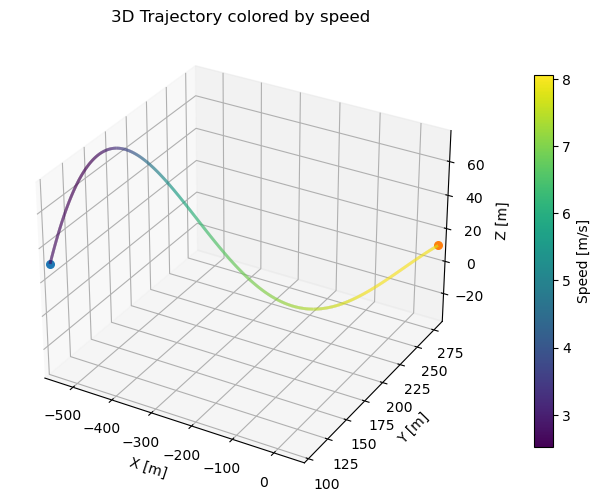

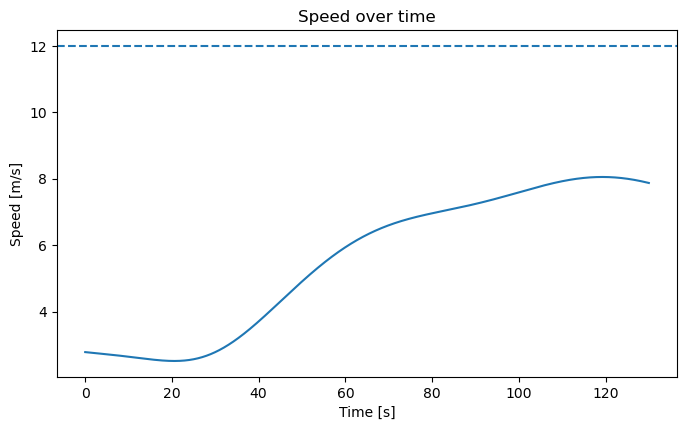

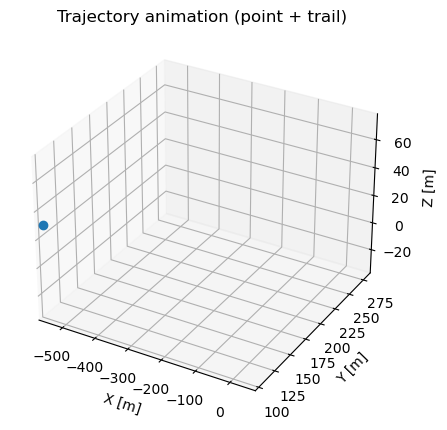

In [16]:

# ----- Generate data -----
t = np.arange(0.0, T, DT)
x, y, z, vx, vy, vz, v_bound, a_bound = build_soft_trajectory(t)
speed = np.sqrt(vx**2 + vy**2 + vz**2)

# ----- 3D curve colored by speed -----
fig = plt.figure(figsize=(8, 6))
ax3d = fig.add_subplot(111, projection='3d')

# Build line segments for a multicolored 3D line
points = np.array([x, y, z]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = Normalize(vmin=speed.min(), vmax=speed.max())
lc = Line3DCollection(segments, cmap=cm.viridis, norm=norm)
lc.set_array(speed[:-1])
lc.set_linewidth(2.0)
ax3d.add_collection3d(lc)

# Add start/end markers
ax3d.scatter([x[0]], [y[0]], [z[0]], s=30)   # start
ax3d.scatter([x[-1]],[y[-1]],[z[-1]], s=30)  # end

# Set axes limits for a nice view
ax3d.set_xlim(np.min(x), np.max(x))
ax3d.set_ylim(np.min(y), np.max(y))
ax3d.set_zlim(np.min(z), np.max(z))
ax3d.set_xlabel("X [m]")
ax3d.set_ylabel("Y [m]")
ax3d.set_zlabel("Z [m]")
cb = fig.colorbar(lc, ax=ax3d, fraction=0.03, pad=0.1)
cb.set_label("Speed [m/s]")
plt.title("3D Trajectory colored by speed")
plt.show()

# ----- Speed vs time plot -----
plt.figure(figsize=(8, 4.5))
plt.plot(t, speed, linewidth=1.5)
plt.axhline(MAX_SPEED, linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title("Speed over time")
plt.show()

# ----- Optional: short GIF animation (moving point + trail) -----
# Keep frames moderate so it renders quickly
sample_step = 4  # use every Nth frame to reduce GIF size
idx = np.arange(0, len(t), sample_step)

fig_anim = plt.figure(figsize=(6, 5))
ax_anim = fig_anim.add_subplot(111, projection='3d')
ax_anim.set_xlim(np.min(x), np.max(x))
ax_anim.set_ylim(np.min(y), np.max(y))
ax_anim.set_zlim(np.min(z), np.max(z))
ax_anim.set_xlabel("X [m]"); ax_anim.set_ylabel("Y [m]"); ax_anim.set_zlabel("Z [m]")
ax_anim.set_title("Trajectory animation (point + trail)")

trail_len = 60  # how many points to keep as a trailing tail (in sampled frames)
point_plot = ax_anim.plot([x[0]], [y[0]], [z[0]], marker='o')[0]
trail_plot, = ax_anim.plot([], [], [], linewidth=2.0)




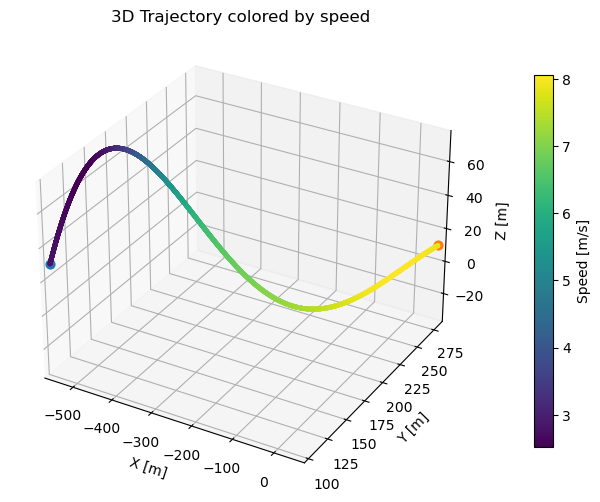

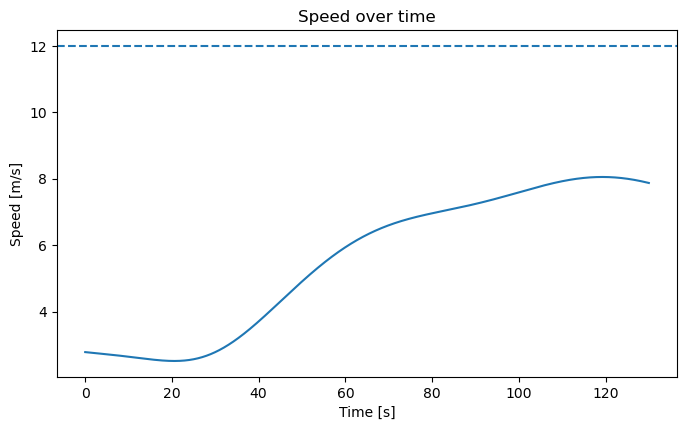

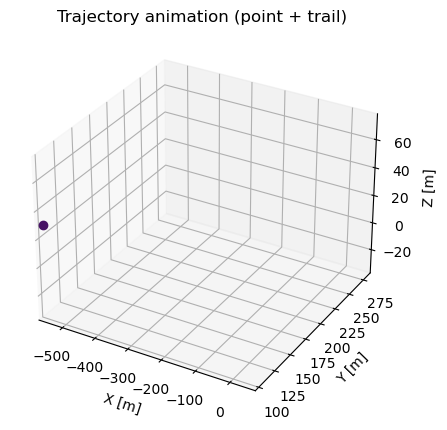

In [ ]:
# ----- Generate data -----
t = np.arange(0.0, T, DT)
x, y, z, vx, vy, vz, v_bound, a_bound = build_soft_trajectory(t)
speed = np.sqrt(vx**2 + vy**2 + vz**2)

# ----- 3D trajectory colored by speed (no Line3DCollection) -----
fig = plt.figure(figsize=(8, 6))
ax3d = fig.add_subplot(111, projection='3d')

# optional faint path for continuity
ax3d.plot(x, y, z, linewidth=0.8, alpha=0.4)

# color each point by its instantaneous speed
sc = ax3d.scatter(x, y, z, c=speed, cmap='viridis', s=6)
ax3d.scatter([x[0]],[y[0]],[z[0]], s=40)   # start
ax3d.scatter([x[-1]],[y[-1]],[z[-1]], s=40)  # end

ax3d.set_xlim(np.min(x), np.max(x))
ax3d.set_ylim(np.min(y), np.max(y))
ax3d.set_zlim(np.min(z), np.max(z))
ax3d.set_xlabel("X [m]"); ax3d.set_ylabel("Y [m]"); ax3d.set_zlabel("Z [m]")
cb = fig.colorbar(sc, ax=ax3d, fraction=0.03, pad=0.1)
cb.set_label("Speed [m/s]")
plt.title("3D Trajectory colored by speed")
plt.show()

# ----- Speed vs time -----
plt.figure(figsize=(8, 4.5))
plt.plot(t, speed, linewidth=1.5)
plt.axhline(MAX_SPEED, linestyle='--')
plt.xlabel("Time [s]"); plt.ylabel("Speed [m/s]")
plt.title("Speed over time")
plt.show()

# ----- Animation (point + trail), color point by speed -----
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import cm

sample_step = 4
idx = np.arange(0, len(t), sample_step)

fig_anim = plt.figure(figsize=(6, 5))
ax_anim = fig_anim.add_subplot(111, projection='3d')
ax_anim.set_xlim(np.min(x), np.max(x))
ax_anim.set_ylim(np.min(y), np.max(y))
ax_anim.set_zlim(np.min(z), np.max(z))
ax_anim.set_xlabel("X [m]"); ax_anim.set_ylabel("Y [m]"); ax_anim.set_zlabel("Z [m]")
ax_anim.set_title("Trajectory animation (point + trail)")

trail_len = 60
point_plot, = ax_anim.plot([x[0]],[y[0]],[z[0]], marker='o', linestyle='None')
trail_plot, = ax_anim.plot([], [], [], linewidth=2.0)


# Save if you want a GIF
# anim.save("trajectory.gif", writer=PillowWriter(fps=30))
